# Initialization

## Import

### Import Modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from config.config_type import AllConfig, DataConfig, DataTuneConfig, LearnConfig, SaveConfig, WeaselConfig
from data.get_meta_datasets import get_meta_datasets
from data.get_tune_loaders import get_tune_loaders
from learners.protoseg import ProtoSegLearner
from learners.weasel import WeaselLearner
from models.u_net import UNet
from tasks.optic_disc_cup.datasets import DrishtiDataset, RimOneDataset
from tasks.optic_disc_cup.metrics import calc_print_disc_cup_iou

plt.style.use('dark_background')

### Autoreload Import

In [2]:
%reload_ext autoreload
%autoreload 1
%aimport config.config_type
%aimport data.few_sparse_dataset, data.get_meta_datasets, data.get_tune_loaders
%aimport models.u_net, learners.weasel, learners.protoseg
%aimport tasks.optic_disc_cup.datasets, tasks.optic_disc_cup.metrics

In [3]:
%autoreload now

## All Config

### Short Training

In [4]:
data_config: DataConfig = {
    'num_classes': 3,
    'num_channels': 3,
    'num_workers': 0,
    'batch_size': 1,
    'resize_to': (256, 256)
}

data_tune_config: DataTuneConfig = {
    'list_shots': [5],
    'list_sparsity_point': [50],
    'list_sparsity_grid': [10],
    'list_sparsity_contour': [1],
    'list_sparsity_skeleton': [1],
    'list_sparsity_region': [1]
}

learn_config: LearnConfig = {
    'use_gpu': True,
    'num_epochs': 8,
    'optimizer_lr': 1e-3,
    'optimizer_weight_decay': 5e-5,
    'optimizer_momentum': 0.9,
    'scheduler_step_size': 150,
    'scheduler_gamma': 0.2,
    'last_stored_epoch': -1,
    'tune_freq': 4,
    'meta_used_datasets': 1,
    'meta_iterations': 5
}

save_config: SaveConfig = {
    'ckpt_path': './ckpt/',
    'output_path': './outputs/',
    'exp_name': ''
}

weasel_config: WeaselConfig = {
    'use_first_order': False,
    'update_param_step_size': 0.3,
    'tune_epochs': 6,
    'tune_test_freq': 3
}

all_config: AllConfig = {
    'data': data_config,
    'data_tune': data_tune_config,
    'learn': learn_config,
    'save': save_config,
    'weasel': weasel_config
}

### Long Training

In [10]:
# data_config: DataConfig = {
#     'num_classes': 3,
#     'num_channels': 3,
#     'num_workers': 0,
#     'batch_size': 1,
#     'resize_to': (256, 256)
# }
# 
# data_tune_config: DataTuneConfig = {
#     'list_shots': [20],
#     'list_sparsity_point': [50],
#     'list_sparsity_grid': [10],
#     'list_sparsity_contour': [1],
#     'list_sparsity_skeleton': [1],
#     'list_sparsity_region': [1]
# }
# 
# learn_config: LearnConfig = {
#     'use_gpu': True,
#     'num_epochs': 200,
#     'optimizer_lr': 1e-3,
#     'optimizer_weight_decay': 5e-5,
#     'optimizer_momentum': 0.9,
#     'scheduler_step_size': 150,
#     'scheduler_gamma': 0.2,
#     'last_stored_epoch': -1,
#     'tune_freq': 40,
#     'meta_used_datasets': 1,
#     'meta_iterations': 5
# }
# 
# save_config: SaveConfig = {
#     'ckpt_path': './ckpt/',
#     'output_path': './outputs/',
#     'exp_name': ''
# }
# 
# weasel_config: WeaselConfig = {
#     'use_first_order': False,
#     'update_param_step_size': 0.3,
#     'tune_epochs': 40,
#     'tune_test_freq': 8
# }
# 
# all_config: AllConfig = {
#     'data': data_config,
#     'data_tune': data_tune_config,
#     'learn': learn_config,
#     'save': save_config,
#     'weasel': weasel_config
# }

# Dataset Exploration

## RIM-ONE

### Create Dataset

In [8]:
rim_one_sparsity_params: dict = {
    'contour_radius_dist': 4,
    'contour_radius_thick': 2,
    'skeleton_radius_thick': 4,
    'region_compactness': 0.5
}

rim_one_data = RimOneDataset(
    mode='train',
    num_classes=3,
    num_shots=5,
    resize_to=(256, 256),
    split_seed=0,
    sparsity_params=rim_one_sparsity_params
)

### Check Sparse Masks

C:\Users\pandega\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(256, 256, 3) 219 14 r1_Im037
(256, 256) int8 [0 1 2]


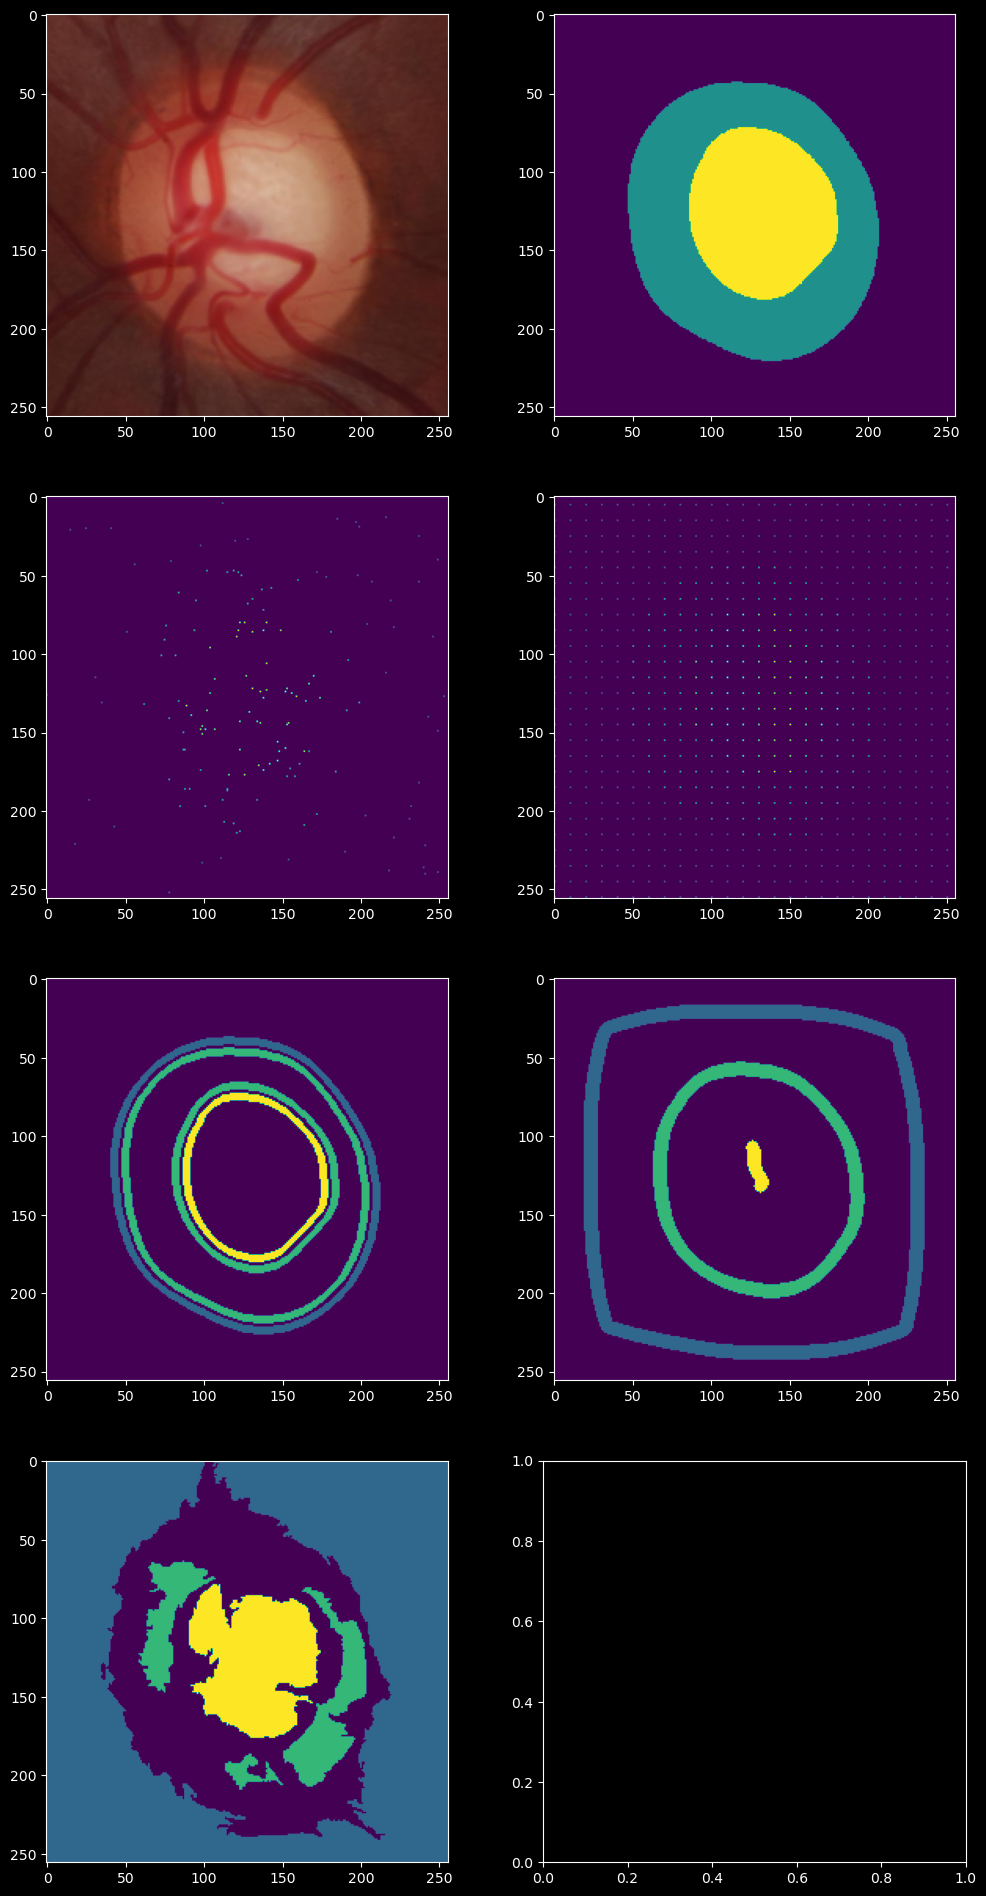

In [9]:
image, mask, sparse_masks, image_filename = rim_one_data.get_data_with_sparse_all(0, 50, 10, 1, 1, 1)
print(image.shape, image.max(), image.min(), image_filename)
print(mask.shape, mask.dtype, np.unique(mask))

n_rows = int(np.ceil(len(sparse_masks) / 2)) + 1 
_, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows*6))
axs = axs.flat
axs[0].imshow(image)
axs[1].imshow(mask)
for i, sm in enumerate(sparse_masks):
    axs[i+2].imshow(sm)

### Check Others

In [10]:
# image_sizes = []
# for image_path, mask_path in rim_one_data.get_all_data_path():
#     image, _ = rim_one_data.read_image_mask(image_path, mask_path)
#     image_sizes.append(image.shape)
# 
# image_sizes = np.array(image_sizes)
# 
# print(np.unique(image_sizes[:,0], return_counts=True))
# print(image_sizes[:,0].min(), image_sizes[:,0].max())
# print(np.unique(image_sizes[:,1], return_counts=True))
# print(image_sizes[:,1].min(), image_sizes[:,1].max())

## DRISHTI

### Create Dataset

In [11]:
drishti_sparsity_params: dict = {
    'contour_radius_dist': 4,
    'contour_radius_thick': 1,
    'skeleton_radius_thick': 3,
    'region_compactness': 0.5
}

drishti_data = DrishtiDataset(
    mode='train',
    num_classes=3,
    num_shots=5,
    resize_to=(256, 256),
    split_seed=0,
    sparsity_params=drishti_sparsity_params
)

### Check Sparse Masks

(256, 256, 3) 255 13 019_cropped
(256, 256) int64 [0 1 2]


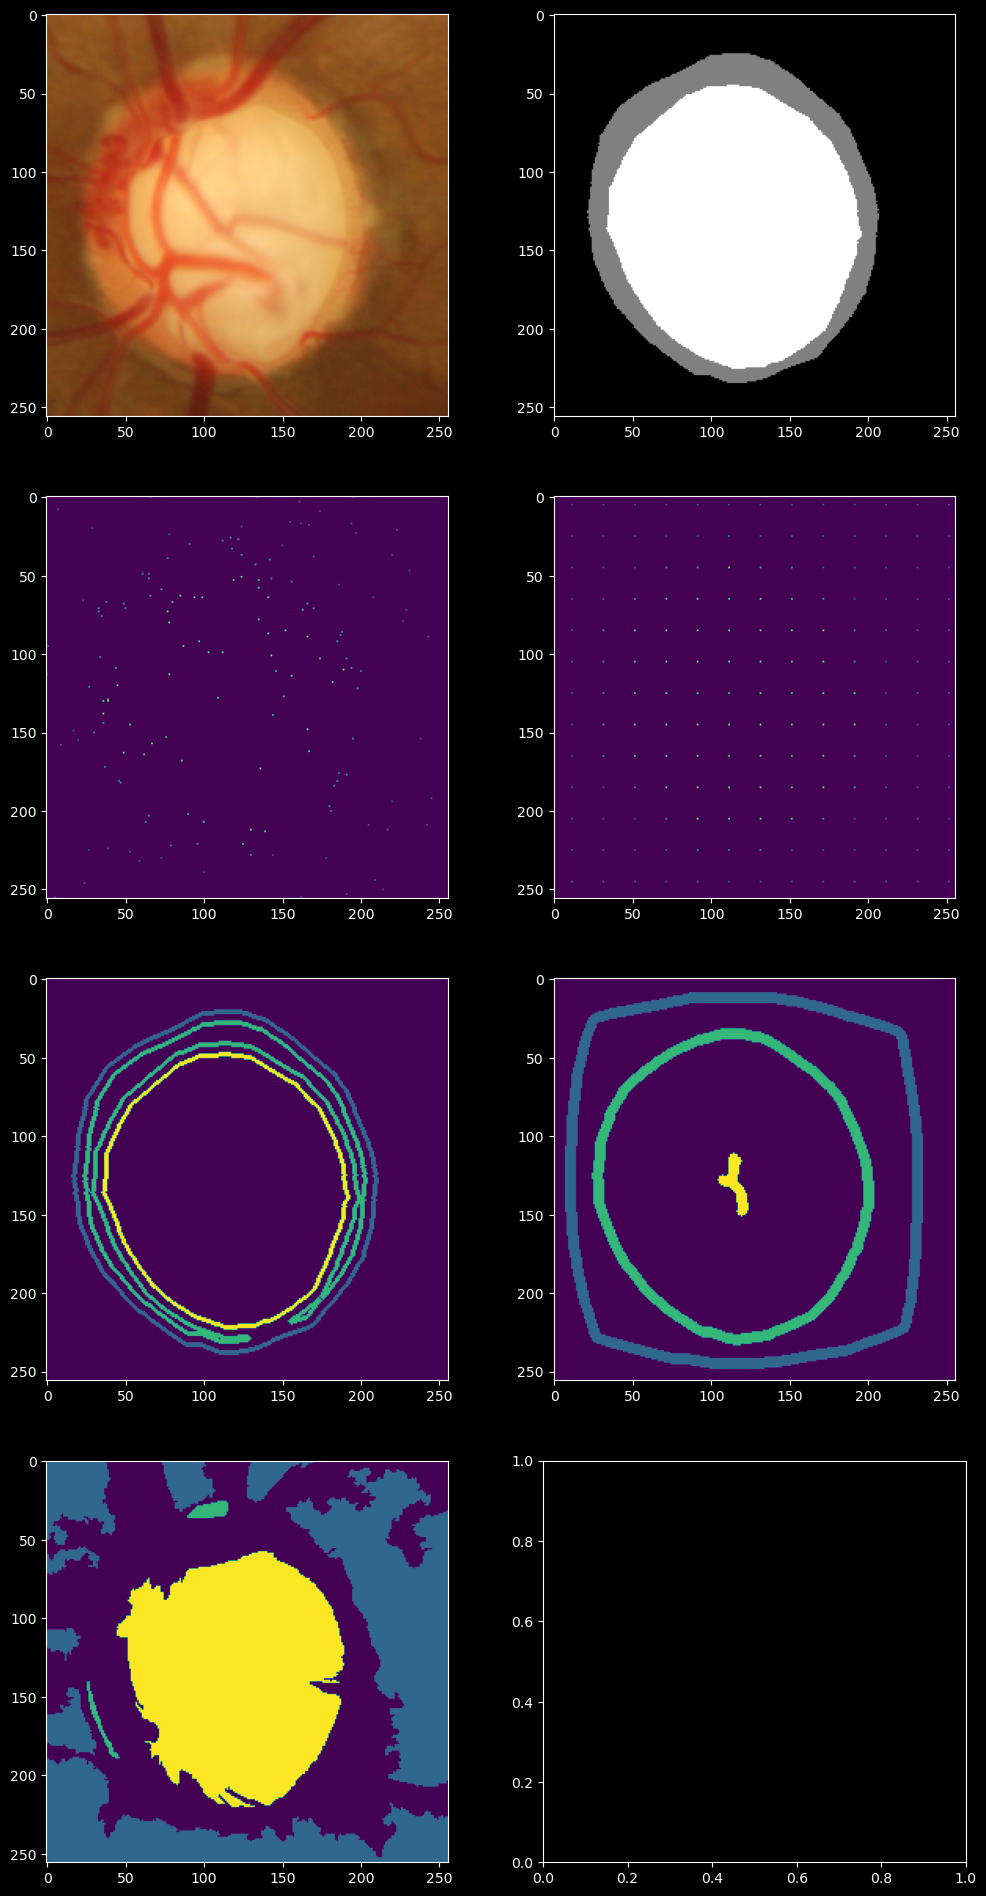

In [12]:
image, mask, sparse_masks, image_filename = drishti_data.get_data_with_sparse_all(1, 50, 20, 1, 1, 1)
print(image.shape, image.max(), image.min(), image_filename)
print(mask.shape, mask.dtype, np.unique(mask))

n_rows = int(np.ceil(len(sparse_masks) / 2)) + 1
_, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows*6))
axs = axs.flat
axs[0].imshow(image)
axs[1].imshow(mask, cmap='gray')
for i, sm in enumerate(sparse_masks):
    axs[i+2].imshow(sm)

### Check Others

In [13]:
# image_sizes = []
# for image_path, mask_path in drishti_data.get_all_data_path():
#     image, _ = rim_one_data.read_image_mask(image_path, mask_path)
#     image_sizes.append(image.shape)
# 
# image_sizes = np.array(image_sizes)
# 
# print(np.unique(image_sizes[:,0], return_counts=True))
# print(image_sizes[:,0].min(), image_sizes[:,0].max())
# print(np.unique(image_sizes[:,1], return_counts=True))
# print(image_sizes[:,1].min(), image_sizes[:,1].max())

# Weasel Learner

## Initialization

### Update Config

In [12]:
all_config['data']['batch_size'] = 3
# all_config['save']['exp_name'] = 'weasel_short_rimone_to_drishti'
all_config['save']['exp_name'] = 'weasel_long_rimone_to_drishti'

### Create Model

In [13]:
net = UNet(all_config['data']['num_channels'], all_config['data']['num_classes'])

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('# of parameters: ' + str(n_params))

# of parameters: 1928483


### Prepare Data

In [14]:
meta_set = get_meta_datasets([
    {
        'dataset_class': RimOneDataset,
        'num_classes': all_config['data']['num_classes'],
        'resize_to': all_config['data']['resize_to'],
        'kwargs': {
            'split_seed': 0,
            'split_test_size': 0.8,
            'sparsity_mode': 'random',
            'sparsity_value': 'random',
            'sparsity_params': rim_one_sparsity_params
        }
    }
])

tune_loader = get_tune_loaders(
    dataset_class=DrishtiDataset,
    dataset_kwargs={
        'split_seed': 0,
        'split_test_size': 0.8,
        'sparsity_mode': 'random',
        'sparsity_value': 'random',
        'sparsity_params': drishti_sparsity_params
    },
    num_classes=all_config['data']['num_classes'],
    resize_to=all_config['data']['resize_to'],
    shots=all_config['data_tune']['list_shots'],
    point=all_config['data_tune']['list_sparsity_point'],
    grid=all_config['data_tune']['list_sparsity_grid'],
    contour=all_config['data_tune']['list_sparsity_contour'],
    skeleton=all_config['data_tune']['list_sparsity_skeleton'],
    region=all_config['data_tune']['list_sparsity_region'],
    batch_size=all_config['data']['batch_size'],
    num_workers=all_config['data']['num_workers']
)

### Create Learner

In [15]:
learner = WeaselLearner(net, all_config, meta_set, tune_loader, calc_print_disc_cup_iou)

## Learning

In [ ]:
learner.learn()

UNet(
  (enc1): _MetaEncoderBlock(
    (encode): MetaSequential(
      (0): MetaConv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MetaBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MetaConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MetaBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (enc2): _MetaEncoderBlock(
    (encode): MetaSequential(
      (0): MetaConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MetaBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MetaConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MetaBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

# Protoseg Learner

## Initialization

### Update Config

In [14]:
all_config['data']['batch_size'] = 5
all_config['save']['exp_name'] = 'protoseg_short_rimone_to_drishti'
# all_config['save']['exp_name'] = 'protoseg_long_rimone_to_drishti'

### Create Model

In [15]:
net = UNet(all_config['data']['num_channels'], all_config['data']['num_classes'])

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('# of parameters: ' + str(n_params))

# of parameters: 1928483


### Prepare Data

In [16]:
meta_set = get_meta_datasets([
    {
        'dataset_class': RimOneDataset,
        'num_classes': all_config['data']['num_classes'],
        'resize_to': all_config['data']['resize_to'],
        'kwargs': {
            'split_seed': 0,
            'split_test_size': 0.8,
            'sparsity_mode': 'random',
            'sparsity_value': 'random',
            'sparsity_params': rim_one_sparsity_params
        }
    }
])

tune_loader = get_tune_loaders(
    dataset_class=DrishtiDataset,
    dataset_kwargs={
        'split_seed': 0,
        'split_test_size': 0.8,
        'sparsity_mode': 'random',
        'sparsity_value': 'random',
        'sparsity_params': drishti_sparsity_params
    },
    num_classes=all_config['data']['num_classes'],
    resize_to=all_config['data']['resize_to'],
    shots=all_config['data_tune']['list_shots'],
    point=all_config['data_tune']['list_sparsity_point'],
    grid=all_config['data_tune']['list_sparsity_grid'],
    contour=all_config['data_tune']['list_sparsity_contour'],
    skeleton=all_config['data_tune']['list_sparsity_skeleton'],
    region=all_config['data_tune']['list_sparsity_region'],
    batch_size=all_config['data']['batch_size'],
    num_workers=all_config['data']['num_workers']
)

### Create Learner

In [17]:
learner = ProtoSegLearner(net, all_config, meta_set, tune_loader, calc_print_disc_cup_iou)

## Learning

In [15]:
learner.learn()

UNet(
  (enc1): _MetaEncoderBlock(
    (encode): MetaSequential(
      (0): MetaConv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MetaBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MetaConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MetaBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (enc2): _MetaEncoderBlock(
    (encode): MetaSequential(
      (0): MetaConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MetaBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MetaConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MetaBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protoseg_long_rimone_to_drishti\points_(5-shot_50-points)_train_epoch_200\015_cropped_sparse.png is a low contrast image
  io.imsave(os.path.join(self.config['save']['output_path'], self.config['save']['exp_name'],
D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protoseg_long_rimone_to_drishti\points_(5-shot_50-points)_train_epoch_200\001_cropped_sparse.png is a low contrast image
  io.imsave(os.path.join(self.config['save']['output_path'], self.config['save']['exp_name'],
D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protoseg_long_rimone_to_drishti\points_(5-shot_50-points)_train_epoch_200\017_cropped_sparse.png is a low contrast image
  io.imsave(os.path.join(self.config['save']['output_path'], self.config['save']['exp_name'],
D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protose

    Evaluating 'grid' (5-shot, 10-spacing)...
--------------------------------------------------------------------
Jaccard test "grid_(5-shot_10-spacing)": Disc = 79.16 | Cup = 71.50
--------------------------------------------------------------------


D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protoseg_long_rimone_to_drishti\grid_(5-shot_10-spacing)_train_epoch_200\001_cropped_sparse.png is a low contrast image
  io.imsave(os.path.join(self.config['save']['output_path'], self.config['save']['exp_name'],
D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protoseg_long_rimone_to_drishti\grid_(5-shot_10-spacing)_train_epoch_200\019_cropped_sparse.png is a low contrast image
  io.imsave(os.path.join(self.config['save']['output_path'], self.config['save']['exp_name'],
D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protoseg_long_rimone_to_drishti\grid_(5-shot_10-spacing)_train_epoch_200\017_cropped_sparse.png is a low contrast image
  io.imsave(os.path.join(self.config['save']['output_path'], self.config['save']['exp_name'],
D:\Penelitian\FWS\few-shot-weakly-seg\learners\protoseg.py:224: UserWarning: ./outputs/protoseg_l

    Evaluating 'contours' (5-shot, 1.00-density)...
--------------------------------------------------------------------
Jaccard test "contours_(5-shot_1.00-density)": Disc = 82.58 | Cup = 67.55
--------------------------------------------------------------------
    Evaluating 'skels' (5-shot, 1.00-skels)...
--------------------------------------------------------------------
Jaccard test "skels_(5-shot_1.00-skels)": Disc = 77.64 | Cup = 52.30
--------------------------------------------------------------------
    Evaluating 'regions' (5-shot, 1.00-regions)...
--------------------------------------------------------------------
Jaccard test "regions_(5-shot_1.00-regions)": Disc = 84.58 | Cup = 66.39
--------------------------------------------------------------------
    Evaluating 'dense' (5-shot)...
--------------------------------------------------------------------
Jaccard test "dense_(5-shot)": Disc = 79.47 | Cup = 71.15
----------------------------------------------------------